<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/Small_Imagenet_RESNET151_vs_VGG19_bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
colorization_path = '/content/drive/MyDrive/colorization'
!tar -zxf /content/drive/MyDrive/colorization/smallval.tar.gz

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [3]:

def stack_lab(l, ab):
  return torch.cat((l, ab), dim=-3)

def lab2rgb(lab, to_numpy):
  dims = len(lab.shape)
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0)) if dims==3 else lab.permute((0,2,3,1))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy(rgb).permute(2,0,1) if dims==3 else torch.from_numpy(rgb).permute((0,3,1,2))

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using Imagenet validation set

In [4]:
# image processing rgb to lab
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.transform = transform
        self.data = datasets.ImageFolder(folder_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, _ = self.data[index]

        if self.transform:
            image = self.transform(image)

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))


        return L, ab

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256,256))
])

# data_dir = '/content/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/'
data_dir = '/content/ILSVRC2012_img_val_subset'
dataset = ColorizationDataset(data_dir, transform)


In [5]:
train_size = int(.8* len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator()
generator.manual_seed(0)
train_data, val_data = random_split(dataset, [train_size, val_size], generator=generator)


In [6]:
gray, chrome = train_data[0]
gray.shape, chrome.shape

(torch.Size([1, 256, 256]), torch.Size([2, 256, 256]))

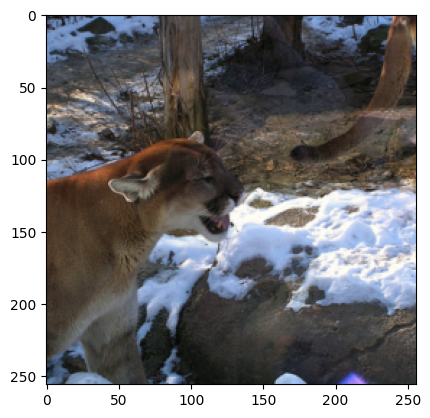

In [7]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

# III. Training Experimentation

## 0. utils

# Compare Resnet and VGG models

In [9]:
! pip install -qU segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00


In [12]:
import segmentation_models_pytorch as smp

class UNet(nn.Module):
  def __init__(self, encoder_name, encoder_weights = 'imagenet', freeze_encoder = True):
    super().__init__()

    self.model = smp.Unet(encoder_name, encoder_weights=encoder_weights, decoder_use_batchnorm=True, in_channels=1)
    self.model.segmentation_head[0] = nn.Conv2d(16, 2, kernel_size=3, padding=1)

    if freeze_encoder:
      for param in self.model.encoder.parameters():
        param.requires_grad = False

  def forward(self, x):
    return self.model(x)

res_unet= UNet(encoder_name='resnet152',encoder_weights='imagenet',freeze_encoder=True)
vgg_unet= UNet(encoder_name='vgg19_bn',encoder_weights='imagenet',freeze_encoder=True)

res_unet.load_state_dict(torch.load('/content/drive/MyDrive/colorization/models/smallimagenet-resunet152.pth'))
vgg_unet.model.load_state_dict(torch.load('/content/drive/MyDrive/colorization/models/small-VGG-UNET-L2.pth'))


<All keys matched successfully>

In [13]:
!pip install -qU lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00


In [14]:
from torch.types import Device
from lpips import LPIPS

lpips_alex = LPIPS(net='alex')

def lpips_evaluate(model, loader):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colors in loader:
            grayscale_images = grayscale_images.to(device)
            colors = colors.to(device)

            # Forward pass
            predicted_colors = model(grayscale_images)

            # Compute the loss
            predicted_rgb = to_rgb(grayscale_images.cpu(), predicted_colors.cpu(), to_numpy = False)
            label_rgb = to_rgb(grayscale_images.cpu(), colors.cpu(), to_numpy = False)

            loss = lpips_alex(predicted_rgb, label_rgb)

            # Accumulate loss
            running_loss += loss.sum().item() / len(loss)

    # Calculate average loss
    average_loss = running_loss / len(loader)

    return average_loss


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 211MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [15]:

testloader = DataLoader(val_data, batch_size=32)
resnet_lpips = lpips_evaluate(res_unet, testloader)
vgg_lpips = lpips_evaluate(vgg_unet, testloader)

print(f'LPIPS results for RESNET backbone:{resnet_lpips}')
print(f'LPIPS results for VGG backbone:{vgg_lpips}')

LPIPS results for RESNET backbone:0.12965077883563936
LPIPS results for VGG backbone:0.12888593948446214


# Colorizing Unseen Data with implemented model

305


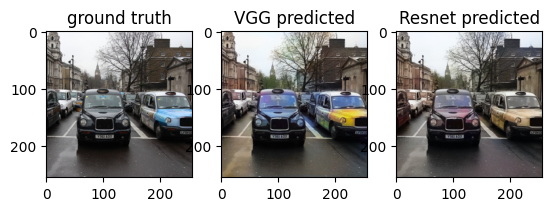

In [99]:
import random
res_unet.eval()
vgg_unet.eval()

index = random.randint(0,len(val_data))
input, label = val_data[index]
rgb_label = to_rgb(input, label)

input = input.to(device)
vgg_output = res_unet(input.unsqueeze(0)).squeeze()
res_output = vgg_unet(input.unsqueeze(0)).squeeze()

rgb_vggpred = to_rgb(input.cpu(), vgg_output.cpu())
rgb_respred = to_rgb(input.cpu(), res_output.cpu())

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0].imshow(rgb_label)
axes[0].set_title('ground truth')

axes[1].imshow(rgb_vggpred)
axes[1].set_title('VGG predicted')

axes[2].imshow(rgb_respred)
axes[2].set_title('Resnet predicted')
print(index)


In [100]:
fig.savefig("/content/drive/MyDrive/colorization/figures/res-vs-vgg31")